# Implementación WCEP para el problema de la mochila (relajado para que sea lineal)

Paper: Counterfactual explanations for linear optimization


In [ ]:
import os

os.environ["GRB_LICENSE_FILE"] = r"C:\Users\PC2\OneDrive\Desktop\gurobi.lic"

import gurobipy as gp
from gurobipy import GRB 

## Forward problem 

Inicialmente, tiene 5 variables x = (x1, x2, x3, x4, x5)

In [4]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np

def generate_and_solve_knapsack_forward(n_items, seed=42):
    """
    Genera y resuelve una instancia de la Mochila Continua.
    Retorna:
        - c_hat (antes v): Peso
        - a_hat: Valor
        - b_hat: valor minimo
        - x_hat, lambda_hat, mu_hat: Solución primal y dual
        - obj_val: Valor óptimo total (c * x)
    """
    np.random.seed(seed)
    
    # 1. Generar Datos
    # Notación: c (beneficio/costo), w (peso)
    a_hat = np.random.uniform(1, 10, n_items)
    c_hat = np.random.uniform(1, 25, n_items) # Antes 'values'
    
    # Capacidad ajustada 
    b_hat = np.random.uniform(5* n_items, 25 * n_items)
    
    # 2. Modelo Gurobi (FORWARD)
    m = gp.Model("Knapsack_Forward")
    m.Params.OutputFlag = 0 
    
    x = m.addVars(n_items, lb=0.0, ub=1.0, name="x")
    
    # Maximizar c^T x
    m.setObjective(gp.quicksum(c_hat[j] * x[j] for j in range(n_items)), GRB.MINIMIZE)

    # Restricción Capacidad (a^T x >= b)
    cap_constr = m.addConstr(gp.quicksum(a_hat[j] * x[j] for j in range(n_items)) >= b_hat, name="Capacity")

    m.optimize()
    
    # 3. Extraer Resultados
    x_val = np.array([x[j].X for j in range(n_items)])
    lambda_val = cap_constr.Pi  # Precio sombra de la capacidad
    
    # Cálculo de mu (Beneficio reducido / Ganancia neta)
    # KKT: mu = max(0, c - lambda*w)
    mu_val = np.minimum(0, c_hat - (lambda_val * a_hat))
    
    return c_hat, a_hat, b_hat, x_val, lambda_val, mu_val, m.ObjVal

# =========================================================
# EJECUCIÓN (SOLO FORWARD)
# =========================================================
n = 5
c_hat, a_hat, b_hat, x_hat, lam_hat, mu_hat, obj_val = generate_and_solve_knapsack_forward(n, seed=42)

print(f"=== PROBLEMA FORWARD (N={n}) ===")
print(f"Capacidad (b): {b_hat:.2f} | Costo del Espacio (Lambda): {lam_hat:.4f}")
print("-" * 85)
print(f"{'Item':<5} | {'Peso (a)':<10} | {'Valor (c)':<10} | {'Costo Espacio':<15} | {'Mu (Gain)':<15} | {'x':<5}")
print("-" * 85)

for j in range(n):
    # Costo que cobra la mochila por guardar este item
    cost_space = lam_hat * a_hat[j]
    
    # Etiquetas para entender qué pasó
    mark = ""
    if x_hat[j] < 0.001: 
        mark = " <-- NO ELEGIDO"
    elif 0.001 < x_hat[j] < 0.999: 
        mark = " <-- SPLIT (Item Marginal)"
    
    print(f"{j:<5} | {a_hat[j]:<10.2f} | {c_hat[j]:<10.2f} | {cost_space:<15.2f} | {mu_hat[j]:<15.2f} | {x_hat[j]:<5.2f}{mark}")

print("-" * 85)
print(f"VALOR ÓPTIMO TOTAL (c*x): {obj_val:.4f}")

=== PROBLEMA FORWARD (N=5) ===
Capacidad (b): 27.06 | Costo del Espacio (Lambda): 2.8714
-------------------------------------------------------------------------------------
Item  | Peso (a)   | Valor (c)  | Costo Espacio   | Mu (Gain)       | x    
-------------------------------------------------------------------------------------
0     | 4.37       | 4.74       | 12.55           | -7.81           | 1.00 
1     | 9.56       | 2.39       | 27.44           | -25.05          | 1.00 
2     | 7.59       | 21.79      | 21.79           | 0.00            | 0.89  <-- SPLIT (Item Marginal)
3     | 6.39       | 15.43      | 18.34           | -2.92           | 1.00 
4     | 2.40       | 17.99      | 6.90            | 0.00            | 0.00  <-- NO ELEGIDO
-------------------------------------------------------------------------------------
VALOR ÓPTIMO TOTAL (c*x): 41.9273


## WCEP para una instancia en particular

Iniciando experimento WCEP (5 runs)...
Restricción: Items [0, 1, 2] son INMUTABLES (Singletons).
Run 0 | Target: Item 0 (Original x=0.00)
Run 1 | Target: Item 0 (Original x=0.00)
Run 2 | Target: Item 0 (Original x=0.00)
Run 3 | Target: Item 4 (Original x=0.00)
Run 4 | Target: Item 3 (Original x=0.00)

RESULTADOS FINALES
   Run  Target    Status       Time  SanityCheck
0    0       0  Feasible  10.079053         True
1    1       0  Feasible   0.068852         True
2    2       0  Feasible   0.125777         True
3    3       4  Feasible   0.349011         True
4    4       3  Feasible   0.099264         True


C:\Users\felip\AppData\Local\Temp\ipykernel_39140\3546260694.py:198: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=status_counts, x="Status", y="Count", ax=axes[1], palette={"Feasible":"green", "Infeasible":"red"})


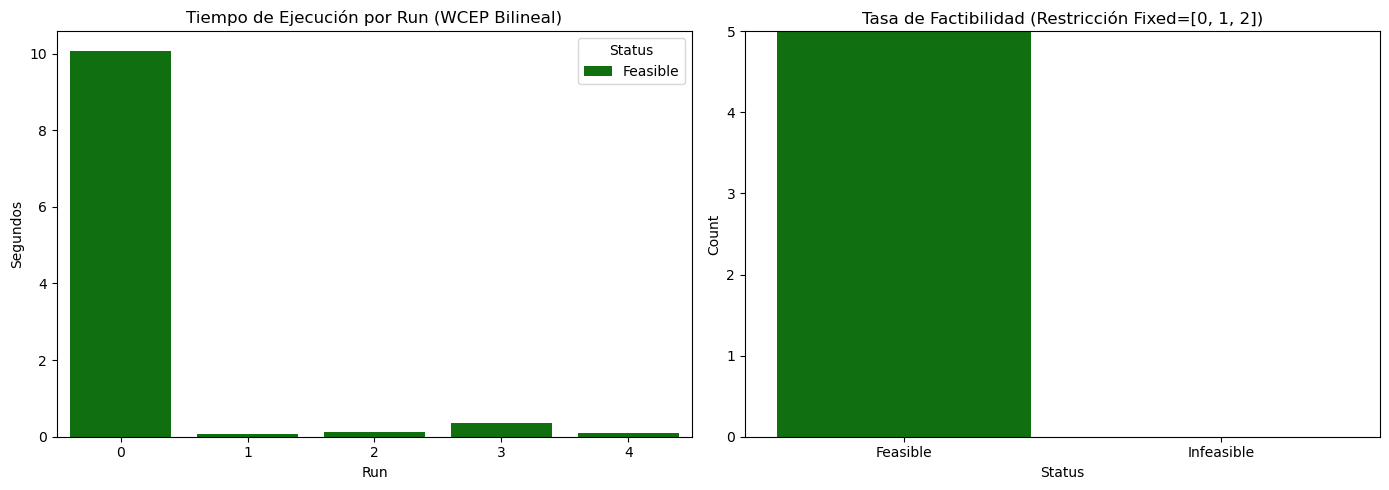

In [ ]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

# =========================================================
# 1. HELPER: RESOLVER FORWARD (Estándar)
# =========================================================
def solve_forward_standard(c, a, b):
    """Resuelve la mochila continua estándar dados parámetros fijos."""
    n = len(c)
    m = gp.Model("Forward_Check")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    
    m.optimize()
    
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. SOLVER WCEP CON "SINGLETONS"
# =========================================================
def solve_wcep_constrained(c_hat, a_hat, b_hat, target_idx, fixed_indices, mutable_Param):
    n = len(c_hat)
    model = gp.Model("WCEP_Constrained")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2  # ¡CRÍTICO! Habilita restricciones cuadráticas
    model.Params.TimeLimit = 20
    
    # --- VARIABLES ---
    # Parámetros modificables (c, a, b)
    c = model.addVars(n, lb=1.0, ub=25, name="c")
    a = model.addVars(n, lb=1.0, ub=10, name="a")
    #-----------------H
    

    # Variables de Certificación (Primal x, Dual lam, mu)
    x = model.addVars(n, lb=0.0, ub=10.0, name="x")
    lam = model.addVar(lb=0.0, name="lambda")
    mu = model.addVars(n, lb=0.0, name="mu")
    
    # --- RESTRICCIONES DE SINGLETONS (H_j fijo) ---
    # Para los índices fijos, forzamos igualdad estricta con el original
    if mutable_Param == 'c':
        for j in fixed_indices:
            model.addConstr(c[j] == c_hat[j], name=f"Fix_c_{j}")
        for j in range(n):
            model.addConstr(a[j] == a_hat[j], name=f"Fix_a_{j}")
        model.addConstr(b == b_hat, name="Fix_b")
    elif mutable_Param == 'a':
        for j in fixed_indices:
            model.addConstr(a[j] == a_hat[j], name=f"Fix_a_{j}")
        for j in range(n):
            model.addConstr(c[j] == c_hat[j], name=f"Fix_c_{j}")
        model.addConstr(b == b_hat, name="Fix_b")
    elif mutable_Param == 'b':
        H = len(fixed_indices)
        b = model.addVar(lb=(25*(n-H)), ub=(25*(n+H)), name="b")
        for j in range(n):
            model.addConstr(c[j] == c_hat[j], name=f"Fix_c_{j}")
            model.addConstr(a[j] == a_hat[j], name=f"Fix_a_{j}")
    else:
        for j in fixed_indices:
            model.addConstr(c[j] == c_hat[j], name=f"Fix_c_{j}")
            model.addConstr(a[j] == a_hat[j], name=f"Fix_a_{j}")
        model.addConstr(b == b_hat, name="Fix_b")
        
    # Acotamos los variables (para que no se vayan a infinito)
    for j in range(n):
        if j not in fixed_indices:
            model.addConstr(c[j] <= c_hat[j]*3) # Cota laxa
            model.addConstr(a[j] <= a_hat[j]*3)
    model.addConstr(b <= b_hat*3)

    # --- KKT / TEOREMA 19 ---
    # 1. Primal Feasibility (Bilineal)
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) <= b)
    
    # 2. Dual Feasibility (Bilineal)
    for j in range(n):
        model.addConstr(lam * a[j] + mu[j] >= c[j])
        
    # 3. Strong Duality (Forzar Optimalidad)
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam + gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj >= d_obj) # Gap 0
    
    # --- CONTRAFACTUAL ---
    model.addConstr(x[target_idx] == 1.0)
    
    # --- OBJETIVO (Distancia L1) ---
    dist = 0
    # Solo sumamos distancia de los NO fijos (los fijos suman 0)
    for j in range(n):
        if j not in fixed_indices:
            dist += (c[j] - c_hat[j])*(c[j] - c_hat[j]) # Usamos L2 prox cuadratico para suavidad
            dist += (w[j] - w_hat[j])*(w[j] - w_hat[j])
            # Nota: Usamos Cuadrático aqui (L2) para ayudar al solver no-convexo, 
            # L1 con abs() añade variables binarias que lo hacen más lento.
            
    dist += (K - K_hat)*(K - K_hat)
    
    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    
    if model.Status == GRB.OPTIMAL:
        # Extraer valores limpios
        c_new = np.array([c[j].X for j in range(n)])
        w_new = np.array([w[j].X for j in range(n)])
        K_new = K.X
        x_wcep = np.array([x[j].X for j in range(n)])
        obj_wcep = sum(c_new * x_wcep)
        return True, c_new, w_new, K_new, x_wcep, obj_wcep
    else:
        return False, None, None, None, None, None

# =========================================================
# 3. EXPERIMENTO: 5 RUNS
# =========================================================
NUM_RUNS = 5
N_ITEMS = 5
FIXED_IDXS = [0, 1, 2] # H1, H2, H3 son singletons

results = []

print(f"Iniciando experimento WCEP ({NUM_RUNS} runs)...")
print(f"Restricción: Items {FIXED_IDXS} son INMUTABLES (Singletons).")
print("="*80)

for r in range(NUM_RUNS):
    seed = 42 + r*100
    np.random.seed(seed)
    
    # 1. Generar Datos Forward Originales
    w_hat = np.random.uniform(5, 20, N_ITEMS)
    c_hat = np.random.uniform(10, 100, N_ITEMS)
    K_hat = np.sum(w_hat) * 0.45
    
    # Resolver original para encontrar un target
    orig_obj, x_orig = solve_forward_standard(c_hat, w_hat, K_hat)
    
    # Buscar Target (el primer item que tenga x=0)
    target = -1
    for j in range(N_ITEMS):
        if x_orig[j] < 0.01:
            target = j
            break
            
    if target == -1:
        print(f"Run {r}: Todos los items seleccionados. Saltando.")
        continue
        
    print(f"Run {r} | Target: Item {target} (Original x={x_orig[target]:.2f})")
    
    # 2. Ejecutar WCEP
    t0 = time.time()
    feasible, c_new, w_new, K_new, x_wcep, obj_wcep = solve_wcep_constrained(c_hat, w_hat, K_hat, target, FIXED_IDXS)
    exec_time = time.time() - t0
    
    status = "Infeasible"
    check_pass = False
    
    if feasible:
        status = "Feasible"
        
        # 3. SANITY CHECK (Prop. 3)
        # Resolvemos el problema forward real con los nuevos parametros
        check_obj, check_x = solve_forward_standard(c_new, w_new, K_new)
        
        # Comparamos Objetivo WCEP vs Objetivo Real
        # Tolerancia pequeña por errores numéricos
        if abs(obj_wcep - check_obj) < 1e-3:
            check_pass = True
            
        # Debug print
        # print(f"   -> WCEP Obj: {obj_wcep:.4f} | Check Obj: {check_obj:.4f} | Match? {check_pass}")
        
    results.append({
        "Run": r,
        "Target": target,
        "Time": exec_time,
        "Status": status,
        "SanityCheck": check_pass
    })

# =========================================================
# 4. REPORTE Y VISUALIZACIÓN
# =========================================================
df = pd.DataFrame(results)

print("\n" + "="*80)
print("RESULTADOS FINALES")
print("="*80)
print(df[["Run", "Target", "Status", "Time", "SanityCheck"]])

# --- GRÁFICOS ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Tiempos de Ejecución
sns.barplot(data=df, x="Run", y="Time", hue="Status", ax=axes[0], palette={"Feasible":"green", "Infeasible":"red"})
axes[0].set_title("Tiempo de Ejecución por Run (WCEP Bilineal)")
axes[0].set_ylabel("Segundos")

# 2. Conteo de Factibilidad
status_counts = df["Status"].value_counts().reset_index()
status_counts.columns = ["Status", "Count"]
# Asegurar que existan ambas categorías para el color
for s in ["Feasible", "Infeasible"]:
    if s not in status_counts["Status"].values:
        new_row = pd.DataFrame({"Status":[s], "Count":[0]})
        status_counts = pd.concat([status_counts, new_row], ignore_index=True)

sns.barplot(data=status_counts, x="Status", y="Count", ax=axes[1], palette={"Feasible":"green", "Infeasible":"red"})
axes[1].set_title(f"Tasa de Factibilidad (Restricción Fixed={FIXED_IDXS})")
axes[1].set_ylim(0, NUM_RUNS)

plt.tight_layout()
plt.show()

In [8]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time

# =========================================================
# 1. HELPER: FORWARD (MINIMIZACIÓN)
# =========================================================
def solve_forward_standard(c, a, b):
    """
    Resuelve: Min cx, s.t. ax >= b, 0 <= x <= 1
    """
    n = len(c)
    m = gp.Model("Forward_Check")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    
    # Minimizar Costo
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    # Sujeto a Beneficio Mínimo
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    
    m.optimize()
    
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

def generate_and_solve_knapsack_forward(n_items, seed=42):
    np.random.seed(seed)
    a_hat = np.random.uniform(5, 15, n_items)   # Coeficiente restricción (Beneficio)
    c_hat = np.random.uniform(1, 10, n_items)   # Coeficiente objetivo (Costo)
    b_hat = np.sum(a_hat) * 0.6                 # RHS (Requerimiento)
    
    val, x_val = solve_forward_standard(c_hat, a_hat, b_hat)
    return c_hat, a_hat, b_hat, x_val, val

# =========================================================
# 2. SOLVER WCEP: EXCLUSIÓN (x=0) CON COLUMNAS (c,a)
# =========================================================
def solve_wcep_columnar(c_hat, a_hat, b_hat, target_idx, fixed_indices, mode_columns=True):
    """
    Resuelve el problema inverso para forzar x[target] = 0.
    
    mode_columns = True  -> Muta columnas (cj, aj) que no estén en fixed_indices. b fijo.
    mode_columns = False -> Muta solo b. Columnas (c,a) fijas.
    """
    n = len(c_hat)
    model = gp.Model("WCEP_Exclusion_Columnar")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2  # Habilita restricciones cuadráticas/bilineales
    model.Params.TimeLimit = 20 # Límite de tiempo
    
    # --- VARIABLES ---
    # Permitimos que c y a varíen dentro de un rango razonable (evitar 0 o infinito)
    c = model.addVars(n, lb=0.1, ub=30.0, name="c") 
    a = model.addVars(n, lb=0.1, ub=30.0, name="a")
    b = model.addVar(lb=0.0, ub=b_hat*2, name="b")
    
    # Variables duales y primales
    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    lam = model.addVar(lb=0.0, name="lambda")
    mu = model.addVars(n, lb=0.0, name="mu")
    
    # --- RESTRICCIONES DE INMUTABILIDAD ---
    if mode_columns:
        # MODO COLUMNAS: b fijo, (c,a) libres salvo fixed_indices
        model.addConstr(b == b_hat, name="Fix_b")
        
        for j in range(n):
            if j in fixed_indices:
                # La columna completa (cj, aj) es inmutable
                model.addConstr(c[j] == c_hat[j], name=f"Fix_c_{j}")
                model.addConstr(a[j] == a_hat[j], name=f"Fix_a_{j}")
            # Si NO está en fixed_indices, son libres
    else:
        # MODO RHS: b libre, todas las columnas fijas
        for j in range(n):
            model.addConstr(c[j] == c_hat[j])
            model.addConstr(a[j] == a_hat[j])
            
    # --- KKT MINIMIZACIÓN ---
    # 1. Primal (>= b)
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    
    # 2. Dual (lam*a - mu <= c)
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
        
    # 3. Strong Duality (Primal <= Dual para forzar igualdad)
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)
    
    # --- CONTRAFACTUAL (EXCLUSIÓN) ---
    # Forzamos que el target salga de la mochila
    model.addConstr(x[target_idx] == 0.0, name="Force_Exclusion")
    
    # --- OBJETIVO ---
    dist = 0
    if mode_columns:
        # Sumar distancias de columnas MUTABLES (cuadráticas)
        for j in range(n):
            if j not in fixed_indices:
                dist += (c[j] - c_hat[j]) * (c[j] - c_hat[j])
                dist += (a[j] - a_hat[j]) * (a[j] - a_hat[j])
    else:
        # Distancia solo de b
        dist += (b - b_hat) * (b - b_hat)

    model.setObjective(dist, GRB.MINIMIZE)
    
    # --- EJECUTAR ---
    model.optimize()
    
    if model.Status == GRB.OPTIMAL:
        return True, np.array([c[j].X for j in range(n)]), \
                     np.array([a[j].X for j in range(n)]), b.X, \
                     np.array([x[j].X for j in range(n)])
    else:
        return False, c_hat, a_hat, b_hat, np.zeros(n)

# =========================================================
# 3. EXPERIMENTO
# =========================================================
NUM_RUNS = 5
N_ITEMS = 6
FIXED_IDXS = [0, 1, 2] # Columnas H1, H2, H3 son inmutables
MODE_COLUMNS = True    # True: Variar (c,a). False: Variar b.

print(f"EXPERIMENTO WCEP: Exclusión (x=0) con Variación de Columnas")
print(f"Modo Variación Columnas: {MODE_COLUMNS} | Indices Fijos: {FIXED_IDXS}")
print("="*100)

for r in range(NUM_RUNS):
    seed = 42 + r*555
    c_hat, a_hat, b_hat, x_orig, val_orig = generate_and_solve_knapsack_forward(N_ITEMS, seed)
    
    # Buscar target para SACAR (alguien que esté dentro, x ~ 1)
    target = -1
    for j in range(N_ITEMS):
        if x_orig[j] > 0.99:
            target = j
            break
            
    if target == -1: 
        print(f"Run {r}: Ningún ítem seleccionado (Mochila vacía). Saltando.")
        continue

    # Resolver WCEP
    feasible, c_new, a_new, b_new, x_new = solve_wcep_columnar(
        c_hat, a_hat, b_hat, target, FIXED_IDXS, mode_columns=MODE_COLUMNS
    )
    
    if not feasible:
        print(f"Run {r} (Target {target}): INFACTIBLE")
        continue

    # Reporte
    print(f"\nRUN {r} | Target {target} (Exclusión: x=1 -> x=0)")
    if not MODE_COLUMNS:
         print(f"    b: {b_hat:.2f} -> {b_new:.2f}")

    print("-" * 105)
    print(f"{'Item':<4} {'St':<6} | {'c Orig':<7} {'c New':<7} {'Dc':<6} | {'a Orig':<7} {'a New':<7} {'Da':<6} | {'x Old':<5} {'x New':<5}")
    print("-" * 105)
    
    for j in range(N_ITEMS):
        is_fixed = j in FIXED_IDXS if MODE_COLUMNS else True
        state = "FIX" if is_fixed else "MUT"
        
        dc = c_new[j] - c_hat[j]
        da = a_new[j] - a_hat[j]
        
        # Formato condicional para ver cambios fácilmente
        str_dc = f"{dc:+.2f}" if abs(dc)>0.01 else " -- "
        str_da = f"{da:+.2f}" if abs(da)>0.01 else " -- "
        
        print(f"{j:<4} {state:<6} | {c_hat[j]:<7.2f} {c_new[j]:<7.2f} {str_dc:<6} | {a_hat[j]:<7.2f} {a_new[j]:<7.2f} {str_da:<6} | {x_orig[j]:<5.2f} {x_new[j]:<5.2f}")
    print("-" * 105)

EXPERIMENTO WCEP: Exclusión (x=0) con Variación de Columnas
Modo Variación Columnas: True | Indices Fijos: [0, 1, 2]

RUN 0 | Target 0 (Exclusión: x=1 -> x=0)
---------------------------------------------------------------------------------------------------------
Item St     | c Orig  c New   Dc     | a Orig  a New   Da     | x Old x New
---------------------------------------------------------------------------------------------------------
0    FIX    | 1.52    1.52     --    | 8.75    8.75     --    | 1.00  0.00 
1    FIX    | 8.80    8.80     --    | 14.51   14.51    --    | 0.56  0.00 
2    FIX    | 6.41    6.41     --    | 12.32   12.32    --    | 1.00  0.00 
3    MUT    | 7.37    2.61    -4.76  | 10.99   14.99   +4.00  | 0.00  1.00 
4    MUT    | 1.19    1.19     --    | 6.56    9.73    +3.17  | 1.00  1.00 
5    MUT    | 9.73    1.93    -7.80  | 6.56    11.09   +4.53  | 0.00  1.00 
-------------------------------------------------------------------------------------------------

## WCEP gráfico 3D cambiando dimensionalidad del H y cantidad de restricciones del D

Iniciando Experimento Grid Search...
N=10 | Runs=5 | b variable: SÍ
[1/16] Mut=1 | Targ=1 -> T=22.801s | Feas=1.0
[2/16] Mut=1 | Targ=2 -> T=3.795s | Feas=1.0
[3/16] Mut=1 | Targ=3 -> T=0.078s | Feas=1.0
[4/16] Mut=1 | Targ=4 -> T=0.138s | Feas=1.0
[5/16] Mut=2 | Targ=1 -> T=96.165s | Feas=0.2
[6/16] Mut=2 | Targ=2 -> T=24.662s | Feas=0.8
[7/16] Mut=2 | Targ=3 -> T=0.151s | Feas=1.0
[8/16] Mut=2 | Targ=4 -> T=0.101s | Feas=1.0
[9/16] Mut=3 | Targ=1 -> T=25.196s | Feas=0.6
[10/16] Mut=3 | Targ=2 -> T=73.560s | Feas=0.2
[11/16] Mut=3 | Targ=3 -> T=0.446s | Feas=1.0
[12/16] Mut=3 | Targ=4 -> T=0.106s | Feas=1.0
[13/16] Mut=4 | Targ=1 -> T=120.210s | Feas=0.0
[14/16] Mut=4 | Targ=2 -> T=120.299s | Feas=0.0
[15/16] Mut=4 | Targ=3 -> T=49.689s | Feas=0.2
[16/16] Mut=4 | Targ=4 -> T=0.623s | Feas=0.8


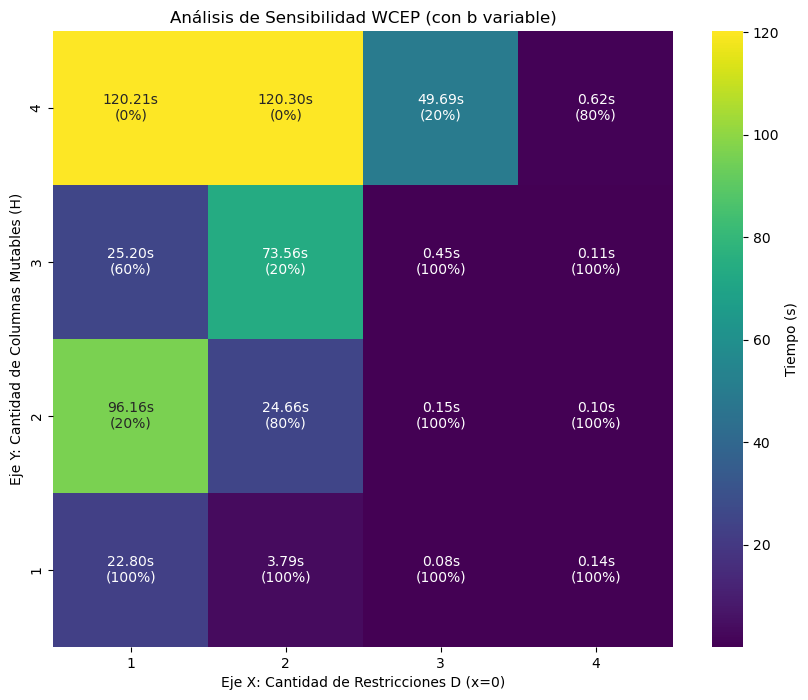

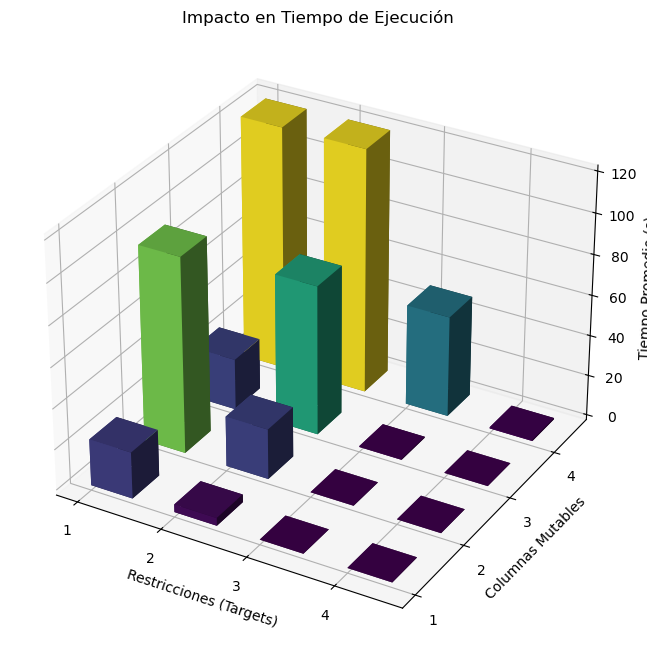

In [2]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# =========================================================
# 1. GENERACIÓN DE DATOS Y FORWARD
# =========================================================
def generate_data(n_items, seed):
    np.random.seed(seed)
    # RANGOS ACTUALIZADOS SEGÚN TU PEDIDO
    a = np.random.uniform(1, 10, n_items)   # Beneficios (filas A)
    c = np.random.uniform(1, 25, n_items)   # Costos (Función objetivo)
    
    # RECOMENDACIÓN PARA B:
    # Usamos un factor aleatorio entre 40% y 60% del beneficio total posible.
    # Esto asegura que el problema sea factible y no trivial.
    # Usar 25*n lo haría infactible (ya que max(a)=10).
    factor = np.random.uniform(0.4, 0.6)
    b = np.sum(a) * factor
    
    return c, a, b

def solve_forward_standard(c, a, b):
    n = len(c)
    m = gp.Model("Forward")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    # Min Costo s.a. Beneficio >= b
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. WCEP COMPLETO (Columnas + b variables)
# =========================================================
def solve_wcep_matrix(c_hat, a_hat, b_hat, target_indices, mutable_indices):
    """
    target_indices (Eje X): Índices forzados a x=0.
    mutable_indices (Eje Y): Índices donde (c, a) pueden cambiar.
    NOTA: b siempre es mutable en esta versión.
    """
    n = len(c_hat)
    model = gp.Model("WCEP_Matrix")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2 
    model.Params.TimeLimit = 120 # 2 minutos máx
    
# --- VARIABLES ---
    # RANGOS AJUSTADOS A LA GENERACIÓN DE DATOS
    # c: Generado en [1, 25] -> Limites [1.0, 25.0]
    c = model.addVars(n, lb=1.0, ub=25.0, name="c") 
    
    # a: Generado en [1, 10] -> Limites [1.0, 10.0]
    a = model.addVars(n, lb=1.0, ub=10.0, name="a")
    
    # b: Límite dinámico pero LÓGICO.
    # El requerimiento 'b' no puede superar físicamente la suma máxima posible de beneficios.
    # Si permitimos que 'a' llegue hasta 10.0 y hay n items:
    max_theoretical_benefit = n * 10.0 
    
    # Le damos un pequeño margen extra (1.1x) por si acaso, pero no 25x.
    # Esto ayuda al solver a podar ramas infactibles rápidamente.
    b = model.addVar(lb=0.0, ub=max_theoretical_benefit * 1.1, name="b")
    
    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    lam = model.addVar(lb=0.0, name="lambda")
    mu = model.addVars(n, lb=0.0, name="mu")
    
    # --- RESTRICCIONES DE INMUTABILIDAD (EJE Y) ---
    # Aquí definimos qué columnas (Hj) quedan fijas.
    # b NO se fija, es libre de variar para ayudar a la factibilidad.
    
    for j in range(n):
        if j not in mutable_indices:
            # Columna Inmutable (Singleton)
            model.addConstr(c[j] == c_hat[j])
            model.addConstr(a[j] == a_hat[j])
            
    # --- KKT (MINIMIZACIÓN) ---
    # 1. Primal: ax >= b
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    # 2. Dual: lam*a - mu <= c
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
    # 3. Strong Duality: Primal <= Dual
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)
    
    # --- CONTRAFACTUAL (EJE X - D) ---
    # Definimos D como la intersección de hiperplanos x_j = 0
    for t_idx in target_indices:
        model.addConstr(x[t_idx] == 0.0)
    
    # --- FUNCIÓN OBJETIVO CORREGIDA ---
    # Distancia ponderada: cambios en columnas + cambio en b
    dist = 0
    
    # 1. Distancia de columnas mutables
    for j in mutable_indices:
        dist += (c[j] - c_hat[j])**2 + (a[j] - a_hat[j])**2
        
    # 2. Distancia de b (¡Ahora incluida!)
    dist += (b - b_hat)**2
        
    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    
    return (model.Status == GRB.OPTIMAL)

# =========================================================
# 3. EXPERIMENTO: MATRIZ DE CONFUSIÓN
# =========================================================
# Configuración
N_ITEMS = 10            # Tamaño del problema
REPEATS = 5             # Runs por celda
RANGES_X = [1, 2, 3, 4] # Cantidad de Targets (x=0)
RANGES_Y = [1, 2, 3, 4] # Cantidad de Columnas Mutables

# Matrices para resultados
time_matrix = np.zeros((len(RANGES_Y), len(RANGES_X)))
feas_matrix = np.zeros((len(RANGES_Y), len(RANGES_X)))

print(f"Iniciando Experimento Grid Search...")
print(f"N={N_ITEMS} | Runs={REPEATS} | b variable: SÍ")
print("="*60)

count = 0
total_cells = len(RANGES_X) * len(RANGES_Y)

for i, num_mutable in enumerate(RANGES_Y):     # Eje Y: Mutabilidad
    for j, num_targets in enumerate(RANGES_X): # Eje X: Restricciones D
        
        cell_times = []
        cell_feas = 0
        
        for r in range(REPEATS):
            seed = 42 + (i*100) + (j*10) + r
            c_hat, a_hat, b_hat = generate_data(N_ITEMS, seed)
            
            # 1. Forward para elegir candidatos
            val, x_orig = solve_forward_standard(c_hat, a_hat, b_hat)
            if x_orig is None: continue # Skip si forward falló (raro)
            
            # Elegir Targets: Items que están DENTRO (x > 0.9)
            active_indices = [k for k, v in enumerate(x_orig) if v > 0.9]
            
            # Relleno si faltan activos (caso borde)
            if len(active_indices) < num_targets:
                rest = [k for k in range(N_ITEMS) if k not in active_indices]
                active_indices.extend(rest[:num_targets - len(active_indices)])
            
            current_targets = active_indices[:num_targets]
            
            # Elegir Mutables: Aleatorio del total
            all_idxs = list(range(N_ITEMS))
            # Usamos semilla para consistencia en la selección
            current_mutables = np.random.RandomState(seed).choice(all_idxs, num_mutable, replace=False)
            
            # 2. WCEP
            t0 = time.time()
            is_optimal = solve_wcep_matrix(c_hat, a_hat, b_hat, current_targets, current_mutables)
            dt = time.time() - t0
            
            cell_times.append(dt)
            if is_optimal: cell_feas += 1
            
        # Promedios
        avg_t = np.mean(cell_times) if cell_times else 0
        avg_f = cell_feas / REPEATS
        
        time_matrix[i, j] = avg_t
        feas_matrix[i, j] = avg_f
        
        count += 1
        print(f"[{count}/{total_cells}] Mut={num_mutable} | Targ={num_targets} -> T={avg_t:.3f}s | Feas={avg_f:.1f}")

# =========================================================
# 4. VISUALIZACIÓN
# =========================================================

# A) Heatmap 2D
plt.figure(figsize=(10, 8))
# Usamos annot_kws para mostrar Tiempo y Factibilidad en la misma celda
annot_labels = np.empty_like(time_matrix, dtype=object)
for i in range(len(RANGES_Y)):
    for j in range(len(RANGES_X)):
        annot_labels[i, j] = f"{time_matrix[i, j]:.2f}s\n({feas_matrix[i, j]*100:.0f}%)"

ax = sns.heatmap(time_matrix, annot=annot_labels, fmt="", cmap="viridis",
                 xticklabels=RANGES_X, yticklabels=RANGES_Y, cbar_kws={'label': 'Tiempo (s)'})
ax.invert_yaxis()
plt.xlabel("Eje X: Cantidad de Restricciones D (x=0)")
plt.ylabel("Eje Y: Cantidad de Columnas Mutables (H)")
plt.title(f"Análisis de Sensibilidad WCEP (con b variable)")
plt.show()

# B) Gráfico 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X_m, Y_m = np.meshgrid(range(len(RANGES_X)), range(len(RANGES_Y)))
X_flat = X_m.flatten()
Y_flat = Y_m.flatten()
Z_flat = np.zeros_like(X_flat)
DX = 0.5 * np.ones_like(Z_flat)
DY = 0.5 * np.ones_like(Z_flat)
DZ = time_matrix.flatten()

# Colorear por altura
from matplotlib import cm
norm = plt.Normalize(DZ.min(), DZ.max())
colors = cm.viridis(norm(DZ))

ax.bar3d(X_flat, Y_flat, Z_flat, DX, DY, DZ, color=colors, shade=True)

ax.set_xticks(range(len(RANGES_X)))
ax.set_xticklabels(RANGES_X)
ax.set_yticks(range(len(RANGES_Y)))
ax.set_yticklabels(RANGES_Y)
ax.set_xlabel('Restricciones (Targets)')
ax.set_ylabel('Columnas Mutables')
ax.set_zlabel('Tiempo Promedio (s)')
plt.title("Impacto en Tiempo de Ejecución")
plt.show()

Iniciando Experimento Grid Search...
N=10 | Runs=5 | b variable: SÍ
Set parameter Username
Set parameter LicenseID to value 2748035
Academic license - for non-commercial use only - expires 2026-12-01
[1/16] Mut=1 | Targ=1 -> T=0.001s | Feas=0.0
[2/16] Mut=1 | Targ=2 -> T=0.001s | Feas=0.0
[3/16] Mut=1 | Targ=3 -> T=0.001s | Feas=0.0
[4/16] Mut=1 | Targ=4 -> T=0.001s | Feas=0.0
[5/16] Mut=2 | Targ=1 -> T=0.001s | Feas=0.0
[6/16] Mut=2 | Targ=2 -> T=0.000s | Feas=0.0
[7/16] Mut=2 | Targ=3 -> T=0.001s | Feas=0.0
[8/16] Mut=2 | Targ=4 -> T=0.002s | Feas=0.0
[9/16] Mut=3 | Targ=1 -> T=0.001s | Feas=0.0
[10/16] Mut=3 | Targ=2 -> T=0.000s | Feas=0.0
[11/16] Mut=3 | Targ=3 -> T=0.000s | Feas=0.0
[12/16] Mut=3 | Targ=4 -> T=0.001s | Feas=0.0
[13/16] Mut=4 | Targ=1 -> T=0.002s | Feas=0.0
[14/16] Mut=4 | Targ=2 -> T=0.001s | Feas=0.0
[15/16] Mut=4 | Targ=3 -> T=0.001s | Feas=0.0
[16/16] Mut=4 | Targ=4 -> T=0.001s | Feas=0.0


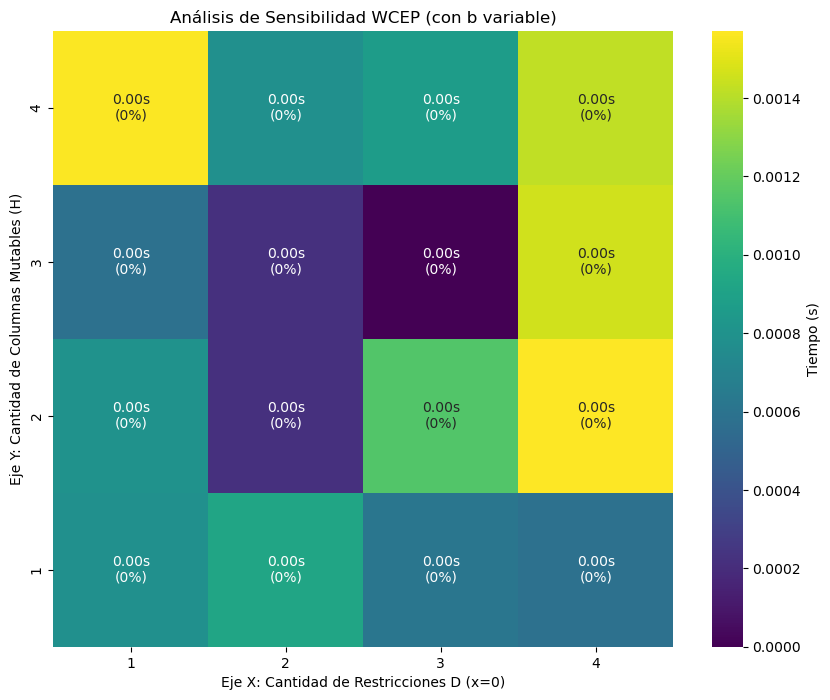

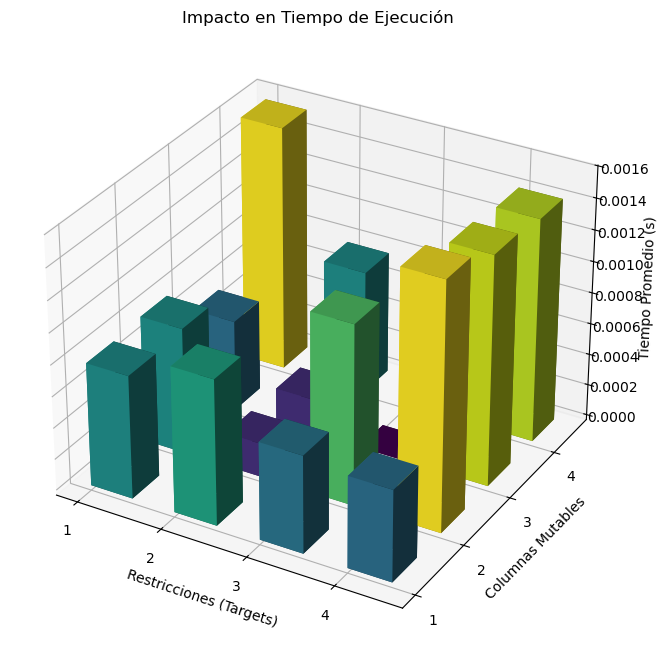

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# =========================================================
# 1. GENERACIÓN DE DATOS Y FORWARD
# =========================================================
def generate_data(n_items, seed):
    np.random.seed(seed)
    # RANGOS ACTUALIZADOS SEGÚN TU PEDIDO
    a = np.random.uniform(1, 10, n_items)   # Beneficios (filas A)
    c = np.random.uniform(1, 25, n_items)   # Costos (Función objetivo)
    
    # RECOMENDACIÓN PARA B:
    # Usamos un factor aleatorio entre 40% y 60% del beneficio total posible.
    # Esto asegura que el problema sea factible y no trivial.
    # Usar 25*n lo haría infactible (ya que max(a)=10).
    factor = np.random.uniform(0.4, 0.6)
    b = np.sum(a) * factor
    
    return c, a, b

def solve_forward_standard(c, a, b):
    n = len(c)
    m = gp.Model("Forward")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    # Min Costo s.a. Beneficio >= b
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. WCEP COMPLETO (Columnas + b variables)
# =========================================================
def solve_wcep_matrix(c_hat, a_hat, b_hat, target_indices, mutable_indices):
    """
    target_indices (Eje X): Índices forzados a x=0.
    mutable_indices (Eje Y): Índices donde (c, a) pueden cambiar.
    NOTA: b siempre es mutable en esta versión.
    """
    n = len(c_hat)
    model = gp.Model("WCEP_Matrix")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2 
    model.Params.TimeLimit = 120 # 2 minutos máx
    
# --- VARIABLES ---
    # RANGOS AJUSTADOS A LA GENERACIÓN DE DATOS
    # c: Generado en [1, 25] -> Limites [1.0, 25.0]
    c = model.addVars(n, lb=1.0, ub=25.0, name="c") 
    
    # a: Generado en [1, 10] -> Limites [1.0, 10.0]
    a = model.addVars(n, lb=1.0, ub=10.0, name="a")
    
    # b: Límite dinámico pero LÓGICO.
    # El requerimiento 'b' no puede superar físicamente la suma máxima posible de beneficios.
    # Si permitimos que 'a' llegue hasta 10.0 y hay n items:
    max_theoretical_benefit = n * 10.0 
    
    H_len = len(mutable_indices)
    b = b_hat * (H_len + 1) * 5
    
    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    lam = model.addVar(lb=0.0, name="lambda")
    mu = model.addVars(n, lb=0.0, name="mu")
    
    # --- RESTRICCIONES DE INMUTABILIDAD (EJE Y) ---
    # Aquí definimos qué columnas (Hj) quedan fijas.
    # b NO se fija, es libre de variar para ayudar a la factibilidad.
    
    for j in range(n):
        if j not in mutable_indices:
            # Columna Inmutable (Singleton)
            model.addConstr(c[j] == c_hat[j])
            model.addConstr(a[j] == a_hat[j])
            
    # --- KKT (MINIMIZACIÓN) ---
    # 1. Primal: ax >= b
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    # 2. Dual: lam*a - mu <= c
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
    # 3. Strong Duality: Primal <= Dual
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)
    
    # --- CONTRAFACTUAL (EJE X - D) ---
    # Definimos D como la intersección de hiperplanos x_j = 0
    for t_idx in target_indices:
        model.addConstr(x[t_idx] == 0.0)
    
    # --- FUNCIÓN OBJETIVO CORREGIDA ---
    # Distancia ponderada: cambios en columnas + cambio en b
    dist = 0
    
    # 1. Distancia de columnas mutables
    for j in mutable_indices:
        dist += (c[j] - c_hat[j])**2 + (a[j] - a_hat[j])**2
        
    # 2. Distancia de b (¡Ahora incluida!)
    dist += (b - b_hat)**2
        
    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    
    return (model.Status == GRB.OPTIMAL)

# =========================================================
# 3. EXPERIMENTO: MATRIZ DE CONFUSIÓN
# =========================================================
# Configuración
N_ITEMS = 10            # Tamaño del problema
REPEATS = 5             # Runs por celda
RANGES_X = [1, 2, 3, 4] # Cantidad de Targets (x=0)
RANGES_Y = [1, 2, 3, 4] # Cantidad de Columnas Mutables

# Matrices para resultados
time_matrix = np.zeros((len(RANGES_Y), len(RANGES_X)))
feas_matrix = np.zeros((len(RANGES_Y), len(RANGES_X)))

print(f"Iniciando Experimento Grid Search...")
print(f"N={N_ITEMS} | Runs={REPEATS} | b variable: SÍ")
print("="*60)

count = 0
total_cells = len(RANGES_X) * len(RANGES_Y)

for i, num_mutable in enumerate(RANGES_Y):     # Eje Y: Mutabilidad
    for j, num_targets in enumerate(RANGES_X): # Eje X: Restricciones D
        
        cell_times = []
        cell_feas = 0
        
        for r in range(REPEATS):
            seed = 42 + (i*100) + (j*10) + r
            c_hat, a_hat, b_hat = generate_data(N_ITEMS, seed)
            
            # 1. Forward para elegir candidatos
            val, x_orig = solve_forward_standard(c_hat, a_hat, b_hat)
            if x_orig is None: continue # Skip si forward falló (raro)
            
            # Elegir Targets: Items que están DENTRO (x > 0.9)
            active_indices = [k for k, v in enumerate(x_orig) if v > 0.9]
            
            # Relleno si faltan activos (caso borde)
            if len(active_indices) < num_targets:
                rest = [k for k in range(N_ITEMS) if k not in active_indices]
                active_indices.extend(rest[:num_targets - len(active_indices)])
            
            current_targets = active_indices[:num_targets]
            
            # Elegir Mutables: Aleatorio del total
            all_idxs = list(range(N_ITEMS))
            # Usamos semilla para consistencia en la selección
            current_mutables = np.random.RandomState(seed).choice(all_idxs, num_mutable, replace=False)
            
            # 2. WCEP
            t0 = time.time()
            is_optimal = solve_wcep_matrix(c_hat, a_hat, b_hat, current_targets, current_mutables)
            dt = time.time() - t0
            
            cell_times.append(dt)
            if is_optimal: cell_feas += 1
            
        # Promedios
        avg_t = np.mean(cell_times) if cell_times else 0
        avg_f = cell_feas / REPEATS
        
        time_matrix[i, j] = avg_t
        feas_matrix[i, j] = avg_f
        
        count += 1
        print(f"[{count}/{total_cells}] Mut={num_mutable} | Targ={num_targets} -> T={avg_t:.3f}s | Feas={avg_f:.1f}")

# =========================================================
# 4. VISUALIZACIÓN
# =========================================================

# A) Heatmap 2D
plt.figure(figsize=(10, 8))
# Usamos annot_kws para mostrar Tiempo y Factibilidad en la misma celda
annot_labels = np.empty_like(time_matrix, dtype=object)
for i in range(len(RANGES_Y)):
    for j in range(len(RANGES_X)):
        annot_labels[i, j] = f"{time_matrix[i, j]:.2f}s\n({feas_matrix[i, j]*100:.0f}%)"

ax = sns.heatmap(time_matrix, annot=annot_labels, fmt="", cmap="viridis",
                 xticklabels=RANGES_X, yticklabels=RANGES_Y, cbar_kws={'label': 'Tiempo (s)'})
ax.invert_yaxis()
plt.xlabel("Eje X: Cantidad de Restricciones D (x=0)")
plt.ylabel("Eje Y: Cantidad de Columnas Mutables (H)")
plt.title(f"Análisis de Sensibilidad WCEP (con b variable)")
plt.show()

# B) Gráfico 3D
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X_m, Y_m = np.meshgrid(range(len(RANGES_X)), range(len(RANGES_Y)))
X_flat = X_m.flatten()
Y_flat = Y_m.flatten()
Z_flat = np.zeros_like(X_flat)
DX = 0.5 * np.ones_like(Z_flat)
DY = 0.5 * np.ones_like(Z_flat)
DZ = time_matrix.flatten()

# Colorear por altura
from matplotlib import cm
norm = plt.Normalize(DZ.min(), DZ.max())
colors = cm.viridis(norm(DZ))

ax.bar3d(X_flat, Y_flat, Z_flat, DX, DY, DZ, color=colors, shade=True)

ax.set_xticks(range(len(RANGES_X)))
ax.set_xticklabels(RANGES_X)
ax.set_yticks(range(len(RANGES_Y)))
ax.set_yticklabels(RANGES_Y)
ax.set_xlabel('Restricciones (Targets)')
ax.set_ylabel('Columnas Mutables')
ax.set_zlabel('Tiempo Promedio (s)')
plt.title("Impacto en Tiempo de Ejecución")
plt.show()

# Comparando la dimensionalidad del H contra la dimensionalidad del D

Iniciando Estudio de Escalabilidad...
Eje X (N): [2, 4, 8, 10]
Eje Y (Mutables): [1, 2, 3, 4]
D constante: Excluir 1 ítem.
[1/16] N=2 | Mut=1 -> T=0.065s
[2/16] N=4 | Mut=1 -> T=0.018s
[3/16] N=8 | Mut=1 -> T=0.044s
[4/16] N=10 | Mut=1 -> T=0.029s
[5/16] N=2 | Mut=2 -> T=0.111s
[6/16] N=4 | Mut=2 -> T=0.149s
[7/16] N=8 | Mut=2 -> T=1.097s
[8/16] N=10 | Mut=2 -> T=0.129s
[9/16] N=2 | Mut=3 -> T=0.000s
[10/16] N=4 | Mut=3 -> T=2.921s
[11/16] N=8 | Mut=3 -> T=1.707s
[12/16] N=10 | Mut=3 -> T=2.459s
[13/16] N=2 | Mut=4 -> T=0.201s
[14/16] N=4 | Mut=4 -> T=2.029s
[15/16] N=8 | Mut=4 -> T=0.132s
[16/16] N=10 | Mut=4 -> T=4.300s


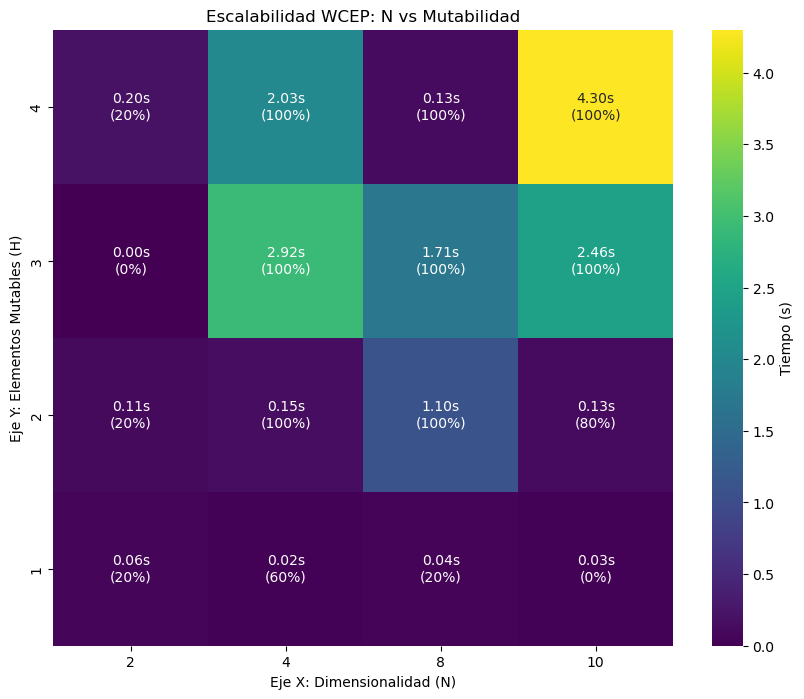

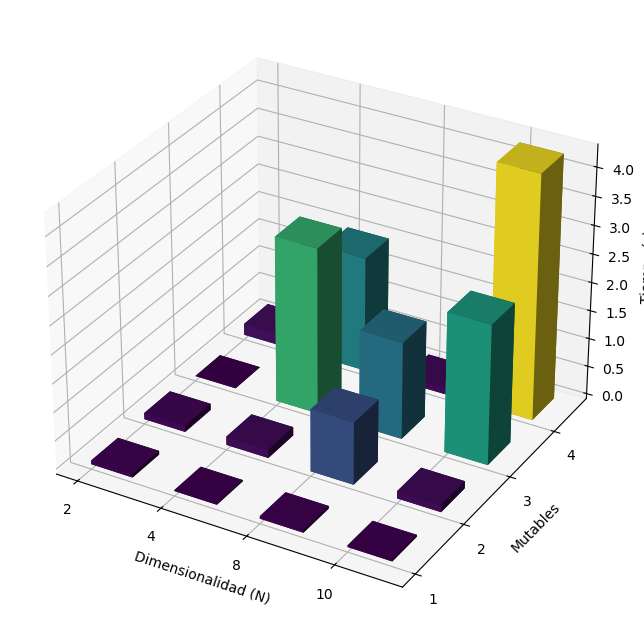

In [3]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# =========================================================
# 1. GENERACIÓN Y FORWARD (ADAPTABLE A N)
# =========================================================
def generate_data(n_items, seed):
    np.random.seed(seed)
    a = np.random.uniform(1, 10, n_items)   # Beneficios
    c = np.random.uniform(1, 25, n_items)   # Costos
    
    # b proporcional al tamaño N para mantener consistencia
    # (aprox 50% de la capacidad teórica promedio)
    factor = np.random.uniform(0.4, 0.6)
    b = np.sum(a) * factor
    
    return c, a, b

def solve_forward_standard(c, a, b):
    n = len(c)
    m = gp.Model("Forward")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. WCEP ROBUSTO (Duales Acotados + b mutable)
# =========================================================
def solve_wcep_matrix(c_hat, a_hat, b_hat, target_indices, mutable_indices):
    n = len(c_hat)
    model = gp.Model("WCEP_Scalability")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2 
    model.Params.TimeLimit = 120
    
    # --- VARIABLES ---
    c = model.addVars(n, lb=1.0, ub=25.0, name="c") 
    a = model.addVars(n, lb=1.0, ub=10.0, name="a")
    
    # Límite físico de b depende de N (n * max_a)
    max_physical_b = n * 10.0
    b = model.addVar(lb=0.0, ub=max_physical_b, name="b")
    
    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    
    # Duales acotados para estabilidad numérica
    lam = model.addVar(lb=0.0, ub=1000.0, name="lambda")
    mu = model.addVars(n, lb=0.0, ub=1000.0, name="mu")
    
    # --- INMUTABILIDAD ---
    # Índice n representa a 'b'
    b_is_mutable = (n in mutable_indices)
    
    if not b_is_mutable:
        model.addConstr(b == b_hat)
    
    for j in range(n):
        if j not in mutable_indices:
            model.addConstr(c[j] == c_hat[j])
            model.addConstr(a[j] == a_hat[j])
            
    # --- KKT ---
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
    
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)
    
    # --- CONTRAFACTUAL (D FIJO: Excluir Target) ---
    for t_idx in target_indices:
        model.addConstr(x[t_idx] == 0.0)
    
    # --- OBJETIVO ---
    dist = 0
    for j in range(n):
        if j in mutable_indices:
            dist += (c[j] - c_hat[j])**2 + (a[j] - a_hat[j])**2
    if b_is_mutable:
        dist += (b - b_hat)**2
        
    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    
    return (model.Status == GRB.OPTIMAL)

# =========================================================
# 3. EXPERIMENTO: ESCALABILIDAD (N vs Mutabilidad)
# =========================================================
# EJE X: Dimensionalidad N
RANGES_X_N = [2, 4, 8, 10] 

# EJE Y: Cantidad de Mutables
RANGES_Y_MUT = [1, 2, 3, 4]

REPEATS = 5
FIXED_TARGET_COUNT = 1  # Siempre excluimos 1 ítem (D constante)

time_matrix = np.zeros((len(RANGES_Y_MUT), len(RANGES_X_N)))
feas_matrix = np.zeros((len(RANGES_Y_MUT), len(RANGES_X_N)))

print(f"Iniciando Estudio de Escalabilidad...")
print(f"Eje X (N): {RANGES_X_N}")
print(f"Eje Y (Mutables): {RANGES_Y_MUT}")
print(f"D constante: Excluir {FIXED_TARGET_COUNT} ítem.")
print("="*60)

count = 0
total_cells = len(RANGES_X_N) * len(RANGES_Y_MUT)

for i, num_mutable in enumerate(RANGES_Y_MUT):     # Filas: Mutabilidad
    for j, n_dim in enumerate(RANGES_X_N):         # Columnas: Tamaño N
        
        cell_times = []
        cell_feas = 0
        
        for r in range(REPEATS):
            seed = 42 + (i*100) + (j*10) + r
            
            # 1. Generar Datos con tamaño n_dim
            c_hat, a_hat, b_hat = generate_data(n_dim, seed)
            
            # Forward
            val, x_orig = solve_forward_standard(c_hat, a_hat, b_hat)
            if x_orig is None: continue
            
            # 2. Seleccionar 1 Target Fijo (D constante)
            # Buscamos el primer ítem activo para sacarlo
            active_indices = [k for k, v in enumerate(x_orig) if v > 0.9]
            
            if not active_indices:
                # Si la mochila está vacía, no hay a quien sacar. 
                # Salto técnico (consideramos tiempo 0, o "factible trivial")
                continue
                
            current_target = [active_indices[0]] # Siempre tamaño 1
            
            # 3. Seleccionar Mutables (Pool size depende de n_dim)
            # Pool = [0...n-1] + [n] (donde n es b)
            pool_size = n_dim + 1
            pool_candidates = list(range(pool_size))
            
            # Cuidado: Si n=2, pool=3 (0,1,b). No podemos pedir 4 mutables.
            # Ajustamos al máximo posible físico.
            actual_k = min(num_mutable, pool_size)
            
            current_mutables = np.random.RandomState(seed).choice(pool_candidates, actual_k, replace=False)
            
            # WCEP
            t0 = time.time()
            is_optimal = solve_wcep_matrix(c_hat, a_hat, b_hat, current_target, current_mutables)
            dt = time.time() - t0
            
            cell_times.append(dt)
            if is_optimal: cell_feas += 1
            
        avg_t = np.mean(cell_times) if cell_times else 0
        avg_f = cell_feas / REPEATS if cell_times else 0
        
        time_matrix[i, j] = avg_t
        feas_matrix[i, j] = avg_f
        
        count += 1
        print(f"[{count}/{total_cells}] N={n_dim} | Mut={num_mutable} -> T={avg_t:.3f}s")

# =========================================================
# 4. VISUALIZACIÓN
# =========================================================

# A) Heatmap
plt.figure(figsize=(10, 8))
annot_labels = np.empty_like(time_matrix, dtype=object)
for i in range(len(RANGES_Y_MUT)):
    for j in range(len(RANGES_X_N)):
        annot_labels[i, j] = f"{time_matrix[i, j]:.2f}s\n({feas_matrix[i, j]*100:.0f}%)"

ax = sns.heatmap(time_matrix, annot=annot_labels, fmt="", cmap="viridis",
                 xticklabels=RANGES_X_N, yticklabels=RANGES_Y_MUT, cbar_kws={'label': 'Tiempo (s)'})
ax.invert_yaxis()
plt.xlabel("Eje X: Dimensionalidad (N)")
plt.ylabel("Eje Y: Elementos Mutables (H)")
plt.title(f"Escalabilidad WCEP: N vs Mutabilidad")
plt.show()

# B) 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X_m, Y_m = np.meshgrid(range(len(RANGES_X_N)), range(len(RANGES_Y_MUT)))
X_flat = X_m.flatten()
Y_flat = Y_m.flatten()
Z_flat = np.zeros_like(X_flat)
DX = 0.5 * np.ones_like(Z_flat)
DY = 0.5 * np.ones_like(Z_flat)
DZ = time_matrix.flatten()

from matplotlib import cm
norm = plt.Normalize(DZ.min(), DZ.max())
colors = cm.viridis(norm(DZ))

ax.bar3d(X_flat, Y_flat, Z_flat, DX, DY, DZ, color=colors, shade=True)

ax.set_xticks(range(len(RANGES_X_N)))
ax.set_xticklabels(RANGES_X_N)
ax.set_yticks(range(len(RANGES_Y_MUT)))
ax.set_yticklabels(RANGES_Y_MUT)
ax.set_xlabel('Dimensionalidad (N)')
ax.set_ylabel('Mutables')
ax.set_zlabel('Tiempo (s)')
plt.show()

Iniciando Estudio de Escalabilidad con SANITY CHECK...
Eje X (N): [10, 12, 14, 16]
Eje Y (Mutables): [1, 2, 3, 4]
[1/16] N=10 | Mut=1 -> T=0.054s | Verified=40%
[2/16] N=12 | Mut=1 -> T=0.041s | Verified=20%
[3/16] N=14 | Mut=1 -> T=0.075s | Verified=20%
[4/16] N=16 | Mut=1 -> T=0.040s | Verified=0%
[5/16] N=10 | Mut=2 -> T=0.818s | Verified=20%
[6/16] N=12 | Mut=2 -> T=0.154s | Verified=20%
[7/16] N=14 | Mut=2 -> T=1.757s | Verified=20%
[8/16] N=16 | Mut=2 -> T=0.254s | Verified=0%
[9/16] N=10 | Mut=3 -> T=0.662s | Verified=40%
[10/16] N=12 | Mut=3 -> T=25.705s | Verified=20%
[11/16] N=14 | Mut=3 -> T=35.669s | Verified=0%
[12/16] N=16 | Mut=3 -> T=0.533s | Verified=40%
[13/16] N=10 | Mut=4 -> T=4.908s | Verified=40%
[14/16] N=12 | Mut=4 -> T=1.848s | Verified=20%
[15/16] N=14 | Mut=4 -> T=12.682s | Verified=40%
[16/16] N=16 | Mut=4 -> T=10.626s | Verified=0%


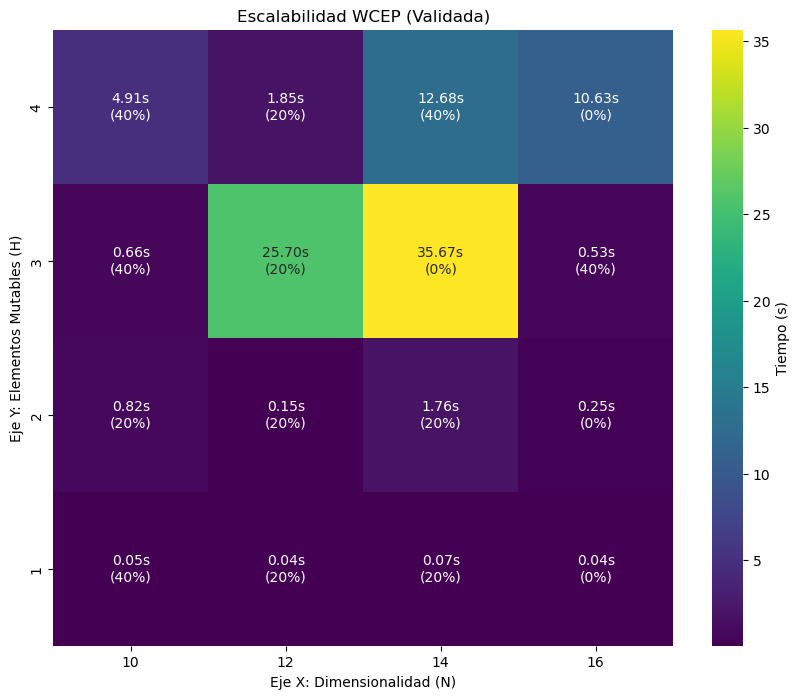

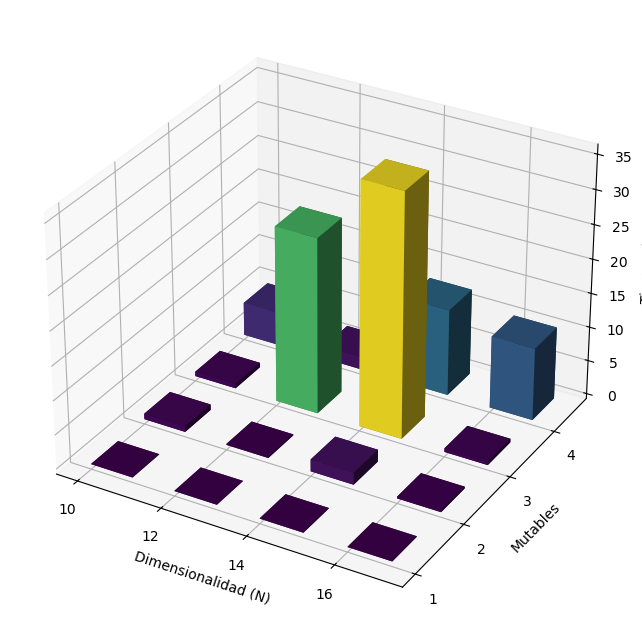

In [4]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D

# =========================================================
# 1. GENERACIÓN Y FORWARD (ADAPTABLE A N)
# =========================================================
def generate_data(n_items, seed):
    np.random.seed(seed)
    a = np.random.uniform(1, 10, n_items)   # Beneficios
    c = np.random.uniform(1, 25, n_items)   # Costos
    
    # b proporcional al tamaño N
    factor = np.random.uniform(0.4, 0.6)
    b = np.sum(a) * factor
    
    return c, a, b

def solve_forward_standard(c, a, b):
    n = len(c)
    m = gp.Model("Forward")
    m.Params.OutputFlag = 0
    x = m.addVars(n, lb=0.0, ub=1.0, name="x")
    m.setObjective(gp.quicksum(c[j] * x[j] for j in range(n)), GRB.MINIMIZE)
    m.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    m.optimize()
    if m.Status == GRB.OPTIMAL:
        return m.ObjVal, np.array([x[j].X for j in range(n)])
    return None, None

# =========================================================
# 2. WCEP ROBUSTO (Retorna nuevos parámetros)
# =========================================================
def solve_wcep_matrix(c_hat, a_hat, b_hat, target_indices, mutable_indices):
    n = len(c_hat)
    model = gp.Model("WCEP_Scalability")
    model.Params.OutputFlag = 0
    model.Params.NonConvex = 2 
    model.Params.TimeLimit = 120
    
    # --- VARIABLES ---
    c = model.addVars(n, lb=1.0, ub=25.0, name="c") 
    a = model.addVars(n, lb=1.0, ub=10.0, name="a")
    
    max_physical_b = n * 10.0
    b = model.addVar(lb=0.0, ub=max_physical_b, name="b")
    
    x = model.addVars(n, lb=0.0, ub=1.0, name="x")
    lam = model.addVar(lb=0.0, ub=1000.0, name="lambda")
    mu = model.addVars(n, lb=0.0, ub=1000.0, name="mu")
    
    # --- INMUTABILIDAD ---
    b_is_mutable = (n in mutable_indices)
    
    if not b_is_mutable:
        model.addConstr(b == b_hat)
    
    for j in range(n):
        if j not in mutable_indices:
            model.addConstr(c[j] == c_hat[j])
            model.addConstr(a[j] == a_hat[j])
            
    # --- KKT ---
    model.addConstr(gp.quicksum(a[j] * x[j] for j in range(n)) >= b)
    for j in range(n):
        model.addConstr(lam * a[j] - mu[j] <= c[j])
    
    p_obj = gp.quicksum(c[j] * x[j] for j in range(n))
    d_obj = b * lam - gp.quicksum(mu[j] for j in range(n))
    model.addConstr(p_obj <= d_obj)
    
    # --- CONTRAFACTUAL ---
    for t_idx in target_indices:
        model.addConstr(x[t_idx] == 0.0)
    
    # --- OBJETIVO ---
    dist = 0
    for j in range(n):
        if j in mutable_indices:
            dist += (c[j] - c_hat[j])**2 + (a[j] - a_hat[j])**2
    if b_is_mutable:
        dist += (b - b_hat)**2
        
    model.setObjective(dist, GRB.MINIMIZE)
    model.optimize()
    
    # RETORNO CON DATOS PARA SANITY CHECK
    if model.Status == GRB.OPTIMAL:
        c_new = np.array([c[j].X for j in range(n)])
        a_new = np.array([a[j].X for j in range(n)])
        b_new = b.X
        return True, c_new, a_new, b_new
    else:
        return False, None, None, None

# =========================================================
# 3. EXPERIMENTO: ESCALABILIDAD (CON SANITY CHECK)
# =========================================================
# EJE X: Dimensionalidad N
RANGES_X_N = [10, 12, 14, 16] 

# EJE Y: Cantidad de Mutables
RANGES_Y_MUT = [1, 2, 3, 4]

REPEATS = 5
FIXED_TARGET_COUNT = 2 

time_matrix = np.zeros((len(RANGES_Y_MUT), len(RANGES_X_N)))
feas_matrix = np.zeros((len(RANGES_Y_MUT), len(RANGES_X_N)))

print(f"Iniciando Estudio de Escalabilidad con SANITY CHECK...")
print(f"Eje X (N): {RANGES_X_N}")
print(f"Eje Y (Mutables): {RANGES_Y_MUT}")
print("="*60)

count = 0
total_cells = len(RANGES_X_N) * len(RANGES_Y_MUT)

for i, num_mutable in enumerate(RANGES_Y_MUT):     # Filas
    for j, n_dim in enumerate(RANGES_X_N):         # Columnas
        
        cell_times = []
        cell_feas_verified = 0 # Contador de casos VERIFICADOS
        
        for r in range(REPEATS):
            seed = 42 + (i*100) + (j*10) + r
            
            # 1. Generar
            c_hat, a_hat, b_hat = generate_data(n_dim, seed)
            
            # Forward Original
            val, x_orig = solve_forward_standard(c_hat, a_hat, b_hat)
            if x_orig is None: continue
            
            # Target (Excluir ítem activo)
            active_indices = [k for k, v in enumerate(x_orig) if v > 0.9]
            if not active_indices: continue
            current_target = [active_indices[0]] 
            target_idx = current_target[0]
            
            # Pool de Mutables
            pool_size = n_dim + 1
            pool_candidates = list(range(pool_size))
            actual_k = min(num_mutable, pool_size)
            current_mutables = np.random.RandomState(seed).choice(pool_candidates, actual_k, replace=False)
            
            # 2. WCEP Solver
            t0 = time.time()
            is_optimal, c_new, a_new, b_new = solve_wcep_matrix(c_hat, a_hat, b_hat, current_target, current_mutables)
            dt = time.time() - t0
            
            cell_times.append(dt)
            
            if is_optimal:
                # =========================================================
                # 3. SANITY CHECK (VERIFICACIÓN)
                # =========================================================
                # Resolvemos el problema forward "limpio" con los nuevos parámetros
                val_check, x_check = solve_forward_standard(c_new, a_new, b_new)
                
                if x_check is not None:
                    # Verificamos si el target efectivamente salió (x < epsilon)
                    # Usamos 1e-4 como tolerancia
                    if x_check[target_idx] < 1e-4:
                        cell_feas_verified += 1
                    else:
                        # Si entra aquí, WCEP mintió o hubo error numérico
                        # print(f"Check Fail: Run {r}, Target era {target_idx}, pero quedó en {x_check[target_idx]:.2f}")
                        pass
                else:
                    # Si el nuevo problema es infactible (raro con b variable, pero posible)
                    pass

        avg_t = np.mean(cell_times) if cell_times else 0
        avg_f = cell_feas_verified / REPEATS if cell_times else 0
        
        time_matrix[i, j] = avg_t
        feas_matrix[i, j] = avg_f
        
        count += 1
        print(f"[{count}/{total_cells}] N={n_dim} | Mut={num_mutable} -> T={avg_t:.3f}s | Verified={avg_f*100:.0f}%")

# =========================================================
# 4. VISUALIZACIÓN
# =========================================================

# A) Heatmap
plt.figure(figsize=(10, 8))
annot_labels = np.empty_like(time_matrix, dtype=object)
for i in range(len(RANGES_Y_MUT)):
    for j in range(len(RANGES_X_N)):
        annot_labels[i, j] = f"{time_matrix[i, j]:.2f}s\n({feas_matrix[i, j]*100:.0f}%)"

ax = sns.heatmap(time_matrix, annot=annot_labels, fmt="", cmap="viridis",
                 xticklabels=RANGES_X_N, yticklabels=RANGES_Y_MUT, cbar_kws={'label': 'Tiempo (s)'})
ax.invert_yaxis()
plt.xlabel("Eje X: Dimensionalidad (N)")
plt.ylabel("Eje Y: Elementos Mutables (H)")
plt.title(f"Escalabilidad WCEP (Validada)")
plt.show()

# B) 3D Plot
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')

X_m, Y_m = np.meshgrid(range(len(RANGES_X_N)), range(len(RANGES_Y_MUT)))
X_flat = X_m.flatten()
Y_flat = Y_m.flatten()
Z_flat = np.zeros_like(X_flat)
DX = 0.5 * np.ones_like(Z_flat)
DY = 0.5 * np.ones_like(Z_flat)
DZ = time_matrix.flatten()

from matplotlib import cm
norm = plt.Normalize(DZ.min(), DZ.max())
colors = cm.viridis(norm(DZ))

ax.bar3d(X_flat, Y_flat, Z_flat, DX, DY, DZ, color=colors, shade=True)

ax.set_xticks(range(len(RANGES_X_N)))
ax.set_xticklabels(RANGES_X_N)
ax.set_yticks(range(len(RANGES_Y_MUT)))
ax.set_yticklabels(RANGES_Y_MUT)
ax.set_xlabel('Dimensionalidad (N)')
ax.set_ylabel('Mutables')
ax.set_zlabel('Tiempo (s)')
plt.show()

# Ver qué es lo que pasa cuando se varia SOLO A, SOLO b, SOLO c, y comparar los tiempos de ejecución a medida que aumenta el x